# Imports and Setup

In [2]:
import pandas as pd
import numpy as np
import neurokit2 as nk
from scipy import stats
import matplotlib.pyplot as plt

# --- 1. SETTINGS AND DATA LOADING ---

# Set the sampling rate and sub-window duration
SAMPLING_RATE = 25  # Hz
WINDOW_SECONDS = 30 # 1 minute
WINDOW_SIZE = SAMPLING_RATE * WINDOW_SECONDS # 1500 data points

# This part of the script will not run on its own, it needs the next blocks.


# Data Loading and Segmentation

In [3]:
# Define the file paths and segment indices for all four sessions.
# Negative indices will be handled dynamically based on signal length.
all_sessions_info = {
    "Aug 5 Afternoon": {
        "filepath": "../PwD dataset/August 5 Afternoon AF 000233/2025-08-05_14-53-04-489951_PG.csv",
        "segments_indices": [(0, 10500), (10500, 19500), (19500, 23950), (-13500, None)]
    },
    "July 22 Afternoon": {
        "filepath": "../PwD dataset/July 22 Afternoon AF 000233/2025-07-22_15-09-31-076964_PG.csv",
        "segments_indices": [(0, 24675), (28425, 28425+4450), (-42000, -42000+6850), (-10500, None)]
    },
    "Aug 5 Morning": {
        "filepath": "../PwD dataset/August 5 Morning AF 000233/2025-08-05_11-19-32-408946_PG.csv",
        "segments_indices": [(0, 19500), (19500, 19500+6750), (19500+6750, 19500+6750+4450), (-12550, None)]
    },
    "July 22 Morning": {
        "filepath": "../PwD dataset/July 22 Morning AF 000233/2025-07-22_10-11-31-907316_PG.csv",
        "segments_indices": [(0, 19500), (96000, 100500), (100500, 100500+4450), (-6000, None)]
    }
}

# This dictionary will store the segmented data for all sessions, ready for analysis.
all_session_data = {}

for session_name, info in all_sessions_info.items():
    print(f"\nLoading and segmenting data for session: {session_name}...")
    try:
        df_ppg = pd.read_csv(info["filepath"])
        ppg_signal = df_ppg["PG"]
        
        # This dictionary will hold the four segments for the current session.
        session_segments = {}
        
        # Iterate through the segment indices to create the four segments.
        for i, (start, end) in enumerate(info["segments_indices"]):
            segment_name = f"Segment {i+1}"
            
            # Handle negative indices for slicing from the end of the signal.
            actual_start = start if start >= 0 else len(ppg_signal) + start
            actual_end = end if end is not None and end >= 0 else (len(ppg_signal) + end if end is not None else None)
            
            # Ensure the slice is valid before taking a copy
            if actual_start < len(ppg_signal):
                session_segments[segment_name] = ppg_signal.iloc[actual_start:actual_end].copy()
            else:
                print(f"  Warning: Segment {i+1} start index is out of bounds. Skipping.")

        all_session_data[session_name] = session_segments
        print(f"  Successfully loaded and segmented {session_name}.")
    except FileNotFoundError:
        print(f"  Error: File not found for {session_name} at path '{info['filepath']}'. Skipping this session.")
    except KeyError:
        print(f"  Error: 'PG' column not found in file for {session_name}. Skipping this session.")
        
print("\nAll sessions loaded and segmented. Ready for analysis.")



Loading and segmenting data for session: Aug 5 Afternoon...
  Successfully loaded and segmented Aug 5 Afternoon.

Loading and segmenting data for session: July 22 Afternoon...
  Successfully loaded and segmented July 22 Afternoon.

Loading and segmenting data for session: Aug 5 Morning...
  Successfully loaded and segmented Aug 5 Morning.

Loading and segmenting data for session: July 22 Morning...
  Successfully loaded and segmented July 22 Morning.

All sessions loaded and segmented. Ready for analysis.


# Sub-Window Analysis Function

In [4]:
# --- 3. SUB-WINDOW ANALYSIS AND METRICS CALCULATION ---

def process_hrv_sub_windows(ppg_data, window_size=1500):
    """
    Splits PPG data into sub-windows and calculates RMSSD on each window.
    Returns a list of RMSSD values for all valid sub-windows.
    """
    rmssd_values = []
    num_windows = len(ppg_data) // window_size
    
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        sub_window_data = ppg_data.iloc[start_idx:end_idx]
        
        if len(sub_window_data) >= window_size:
            try:
                cleaned_ppg = nk.ppg_clean(sub_window_data, sampling_rate=SAMPLING_RATE)
                peaks, info = nk.ppg_peaks(cleaned_ppg, sampling_rate=SAMPLING_RATE)
                hrv_time = nk.hrv_time(peaks, sampling_rate=SAMPLING_RATE)
                rmssd_values.append(hrv_time['HRV_RMSSD'].values[0])
            except Exception as e:
                print(f"Warning: Error processing sub-window, skipping. Error: {e}")
                
    return rmssd_values

all_session_rmssd = {}

for session_name, segments in all_session_data.items():
    print(f"\nPerforming sub-window analysis for {session_name}...")
    session_rmssd = {}
    for segment_name, data in segments.items():
        if not data.empty:
            session_rmssd[segment_name] = process_hrv_sub_windows(data, window_size=WINDOW_SIZE)
            print(f"  '{session_name} - {segment_name}' contains {len(session_rmssd[segment_name])} RMSSD values.")
        else:
            print(f"  Warning: Skipping '{session_name} - {segment_name}' as it is empty.")
    all_session_rmssd[session_name] = session_rmssd


Performing sub-window analysis for Aug 5 Afternoon...
  'Aug 5 Afternoon - Segment 1' contains 14 RMSSD values.
  'Aug 5 Afternoon - Segment 2' contains 12 RMSSD values.
  'Aug 5 Afternoon - Segment 3' contains 5 RMSSD values.
  'Aug 5 Afternoon - Segment 4' contains 18 RMSSD values.

Performing sub-window analysis for July 22 Afternoon...
  'July 22 Afternoon - Segment 1' contains 32 RMSSD values.
  'July 22 Afternoon - Segment 2' contains 5 RMSSD values.
  'July 22 Afternoon - Segment 3' contains 9 RMSSD values.
  'July 22 Afternoon - Segment 4' contains 14 RMSSD values.

Performing sub-window analysis for Aug 5 Morning...


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.12/site-packages/neurokit2/hrv/hrv_time.py:173: RuntimeWarning: Mean of empty slice
  out["RMSSD"] = np.sqrt(np.nanmean(diff_rri**2))


  'Aug 5 Morning - Segment 1' contains 26 RMSSD values.
  'Aug 5 Morning - Segment 2' contains 9 RMSSD values.
  'Aug 5 Morning - Segment 3' contains 5 RMSSD values.
  'Aug 5 Morning - Segment 4' contains 16 RMSSD values.

Performing sub-window analysis for July 22 Morning...
  'July 22 Morning - Segment 1' contains 26 RMSSD values.
  'July 22 Morning - Segment 2' contains 6 RMSSD values.
  'July 22 Morning - Segment 3' contains 5 RMSSD values.
  'July 22 Morning - Segment 4' contains 8 RMSSD values.


# Statistical Comparison

In [5]:
# --- 4. STATISTICAL COMPARISON ---

print("\n--- Performing Pairwise T-tests for each session ---")

for session_name, rmssd_data in all_session_rmssd.items():
    segment_names = list(rmssd_data.keys())
    
    print(f"\nSession: {session_name}")
    
    for i in range(len(segment_names)):
        for j in range(i + 1, len(segment_names)):
            name1 = segment_names[i]
            name2 = segment_names[j]
            sample1 = rmssd_data.get(name1, [])
            sample2 = rmssd_data.get(name2, [])
            
            if len(sample1) > 1 and len(sample2) > 1:
                t_statistic, p_value = stats.ttest_ind(sample1, sample2, equal_var=False)
                
                print(f"  Comparing {name1} vs. {name2}:")
                print(f"    T-statistic: {t_statistic:.3f}")
                print(f"    P-value: {p_value:.3f}")
                
                if p_value < 0.05:
                    print("    Result: The difference in RMSSD means is statistically significant (p < 0.05).")
                else:
                    print("    Result: No significant difference in RMSSD means.")
            else:
                print(f"  Warning: Insufficient samples for t-test for '{name1}' or '{name2}'. Skipping.")




--- Performing Pairwise T-tests for each session ---

Session: Aug 5 Afternoon
  Comparing Segment 1 vs. Segment 2:
    T-statistic: 1.364
    P-value: 0.185
    Result: No significant difference in RMSSD means.
  Comparing Segment 1 vs. Segment 3:
    T-statistic: -0.146
    P-value: 0.890
    Result: No significant difference in RMSSD means.
  Comparing Segment 1 vs. Segment 4:
    T-statistic: 0.950
    P-value: 0.350
    Result: No significant difference in RMSSD means.
  Comparing Segment 2 vs. Segment 3:
    T-statistic: -0.607
    P-value: 0.574
    Result: No significant difference in RMSSD means.
  Comparing Segment 2 vs. Segment 4:
    T-statistic: -0.315
    P-value: 0.755
    Result: No significant difference in RMSSD means.
  Comparing Segment 3 vs. Segment 4:
    T-statistic: 0.491
    P-value: 0.646
    Result: No significant difference in RMSSD means.

Session: July 22 Afternoon
  Comparing Segment 1 vs. Segment 2:
    T-statistic: 0.150
    P-value: 0.885
    Result: 

# Visualization


--- Generating Box Plots ---


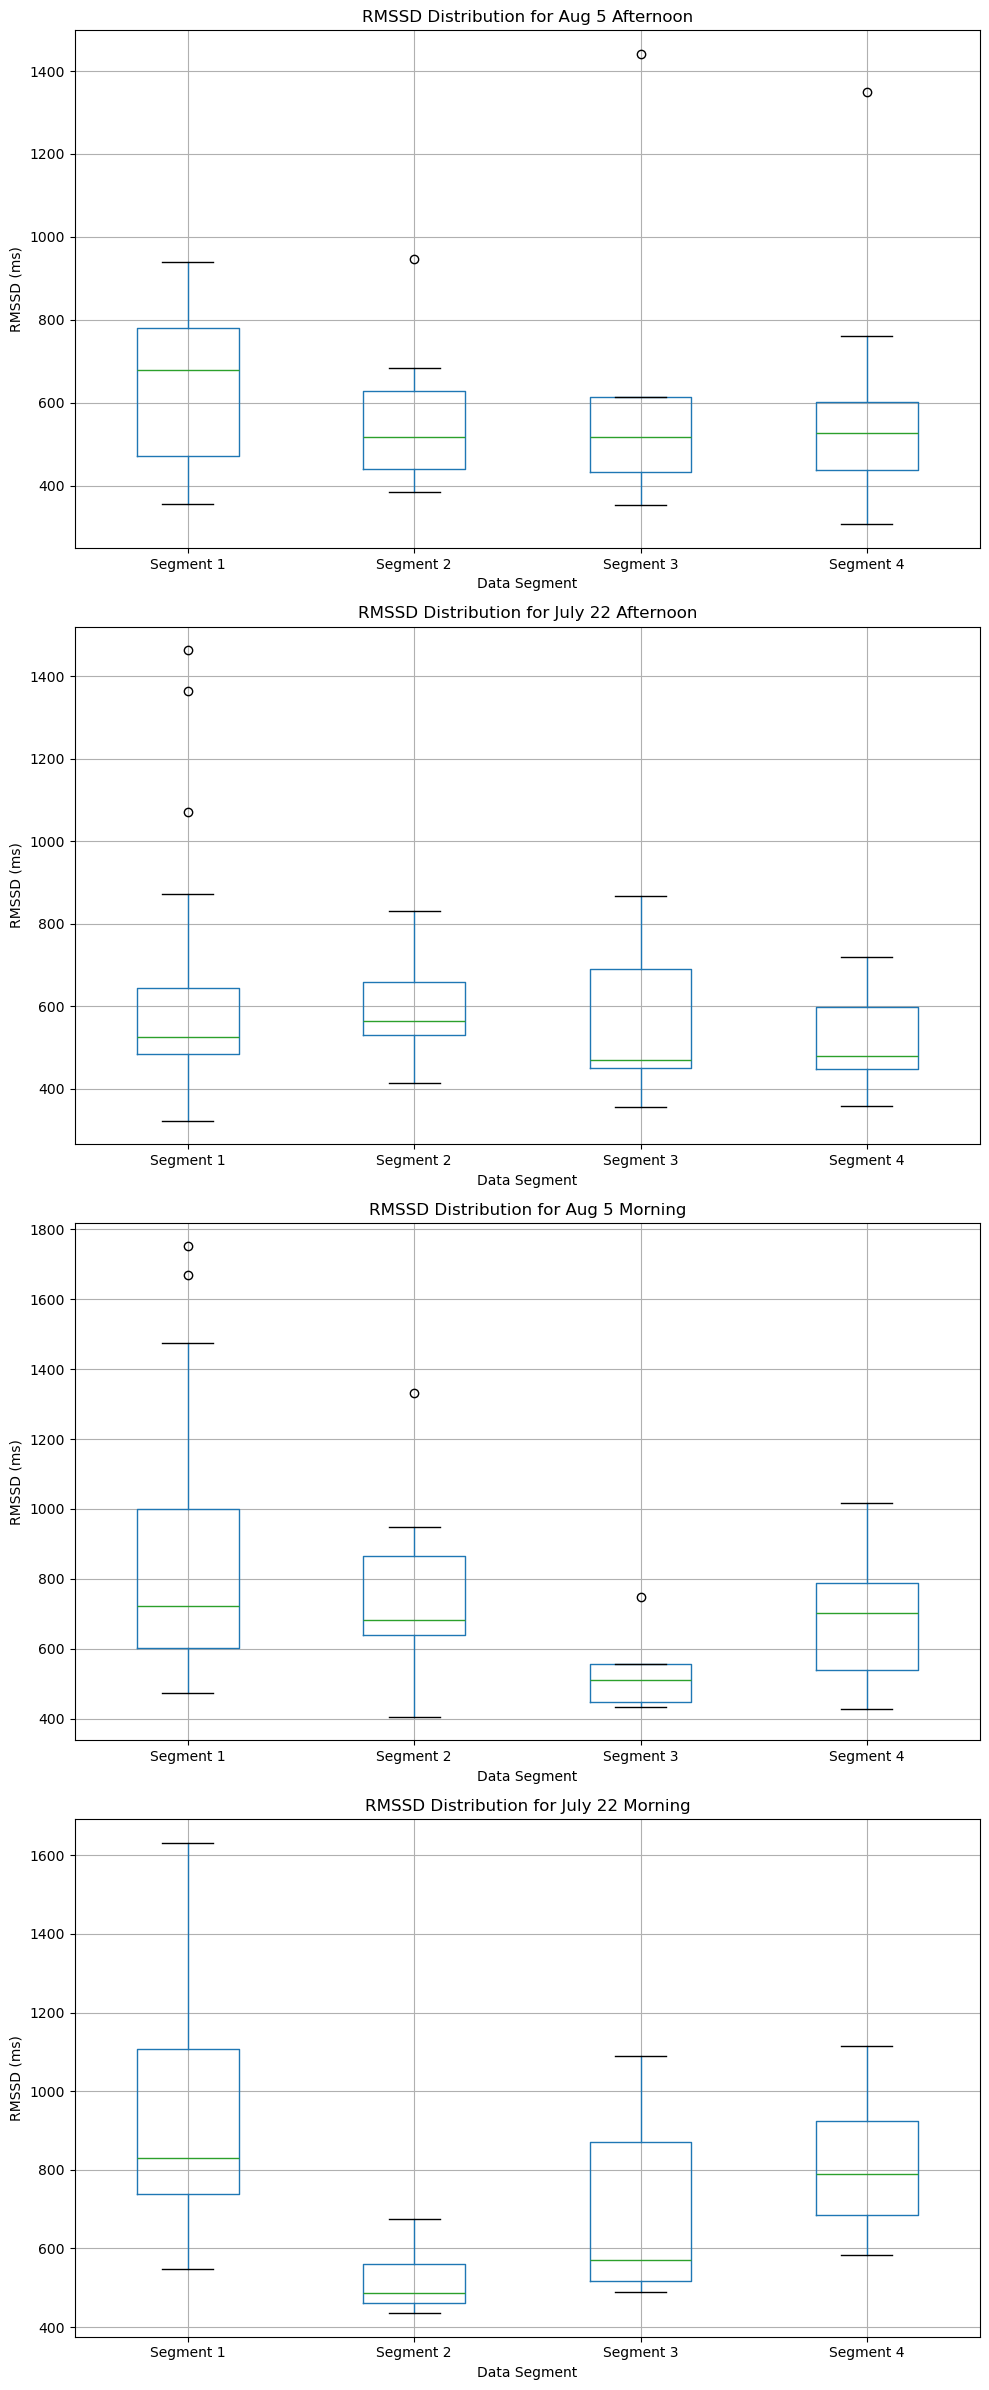

In [6]:
# --- 5. RESULT VISUALIZATION ---

print("\n--- Generating Box Plots ---")

# Create a figure with a subplot for each session
num_sessions = len(all_session_rmssd)
fig, axes = plt.subplots(nrows=num_sessions, ncols=1, figsize=(10, 6 * num_sessions))

if num_sessions == 1:
    axes = [axes] # Make axes iterable even for a single subplot

for i, (session_name, rmssd_data) in enumerate(all_session_rmssd.items()):
    plot_df = pd.DataFrame({
        name: pd.Series(values) for name, values in rmssd_data.items()
    })

    if not plot_df.empty:
        plot_df.boxplot(ax=axes[i])
        axes[i].set_title(f"RMSSD Distribution for {session_name}")
        axes[i].set_ylabel("RMSSD (ms)")
        axes[i].set_xlabel("Data Segment")
        axes[i].grid(True)

plt.tight_layout()
plt.show()
